This notebook aims to provide a quantification of the Actions (and their releases) from the dataset, as well as some insights about the release frequency of Actions and the evolution of this frequency through time. It also provides insight on how frequently workflows are updated in repositories using GHA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn
import lifelines

In [73]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (9, 3)

PALETTE = seaborn.color_palette()
DATE_RANGE = pd.to_datetime('2019-11-01'), pd.to_datetime('2022-08-31')
REL_CENSOR = pd.to_datetime('2018-10-16')  # Limited public beta of GHA

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SEED = 12345
SAVEFIG = False

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

### Load data

In [74]:
# Releases of Actions
df_releases = (
    pd.read_csv('../data/releases.csv.gz')
    .assign(date=lambda d: pd.to_datetime(d.date, errors='coerce').dt.tz_convert(None))
    # Convert to lower case since a repository is not case-sensitive.
    .assign(owner=lambda d: d.owner.str.lower())
    .assign(repo=lambda d: d.repo.str.lower())
    .rename(columns={'release': 'version'})
    [lambda d: d.date.between(REL_CENSOR, DATE_RANGE[1], inclusive='both')]
    [['owner', 'repo', 'version', 'date']]
)

In [66]:
# Updates of workflows


### Data overview

#### Evolution of the number of Actions and releases

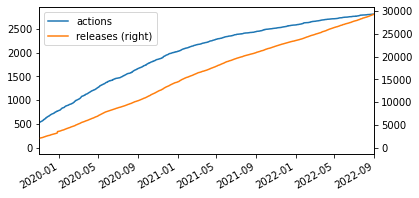

In [67]:
fig, ax = matplotlib.pyplot.subplots()
# fig.set_size_inches(FIG_SIZE)

temp = (
    df_releases
    .sort_values('date', ascending=True)
    .drop_duplicates(['owner', 'repo'], keep='first')
    .assign(actions=lambda d: range(1, len(d) + 1))
    .merge(
        df_releases.sort_values('date', ascending=True).assign(releases=lambda d: range(1, len(d) + 1)),
        how='right',
        on=['owner', 'repo', 'date'],
    )
    [['date', 'owner', 'repo', 'actions', 'releases']]
    .fillna(method='ffill')
)

(
    temp
    .set_index('date')
    [['actions', 'releases']]
    .plot(secondary_y='releases', ax=ax, color=PALETTE)
)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel=None
)

savefig(fig, 'rel_evolution')

In [68]:
display(temp[lambda d: d.date >= DATE_RANGE[0]].iloc[0])
display(temp.iloc[-1])

date        2019-11-01 00:39:31
owner                 errata-ai
repo                vale-action
actions                   531.0
releases                   2078
Name: 2077, dtype: object

date        2022-08-31 23:37:28
owner              jpetrucciani
repo                black-check
actions                  2811.0
releases                  29305
Name: 29304, dtype: object

#### Monthly number of releases

#### Monthly proportion of Actions being updated

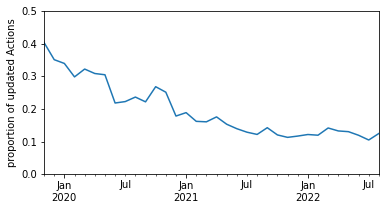

In [86]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .sort_values('date', ascending=True)
    .drop_duplicates(['owner', 'repo'], keep='first')
    .assign(actions=lambda d: range(1, len(d) + 1))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg({'actions': 'max'})
    .merge(
        df_releases
        .assign(repository=lambda d: d.owner + '/' + d.repo)
        .groupby(pd.Grouper(key='date', freq='M'))
        .agg(updated=('repository', 'nunique')),
        how='outer',
        left_index=True,
        right_index=True,
    )
    .assign(proportion=lambda d: d['updated'] / d['actions'])
)

temp[['proportion']].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylim=(0, 0.5), 
    ylabel='proportion of updated Actions'
)
ax.legend().remove()

savefig(fig, 'rel_prop_updated')

In [76]:
temp.iloc[-1]

actions       2811.000000
updated        351.000000
proportion       0.124867
Name: 2022-08-31 00:00:00, dtype: float64

#### Evolution of the number of repositories using GHA

#### Evolution of the number of workflow updates

#### Monthly proportion of repositories updating a workflow file

### Release frequency

#### Distribution of the number of releases

#### Distribution of the time since last update

#### Evolution of the time since last update